In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from collections import Counter
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

import warnings
warnings.filterwarnings("ignore")


In [6]:
reddit = pd.read_csv('/content/drive/MyDrive/Sentiment_analysis/Reddit_Data.csv')

In [7]:
twitter = pd.read_csv('/content/drive/MyDrive/Sentiment_analysis/Twitter_Data.csv')

In [8]:
print(reddit.shape)
reddit.head()

(37249, 2)


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [9]:
print(twitter.shape)
twitter.head()

(162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
twitter = twitter.rename(columns={'clean_text': 'clean_comment'})

In [11]:
df = pd.concat((reddit, twitter), axis = 0, ignore_index=True)

In [12]:
df.shape

(200229, 2)

In [13]:
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [14]:
df.isna().sum()

clean_comment    104
category           7
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.duplicated().sum()

410

In [17]:
df = df.drop_duplicates()

In [18]:
df.shape

(199708, 2)

- -1 = Negetive
- 0 = Neutral
- 1 = Positive

<Axes: xlabel='category', ylabel='count'>

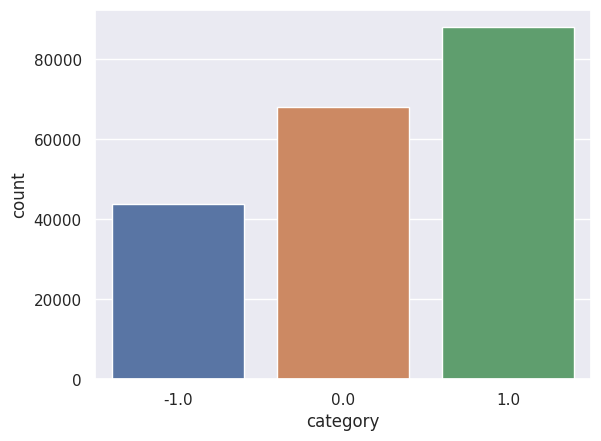

In [19]:
sns.countplot(data=df, x='category')


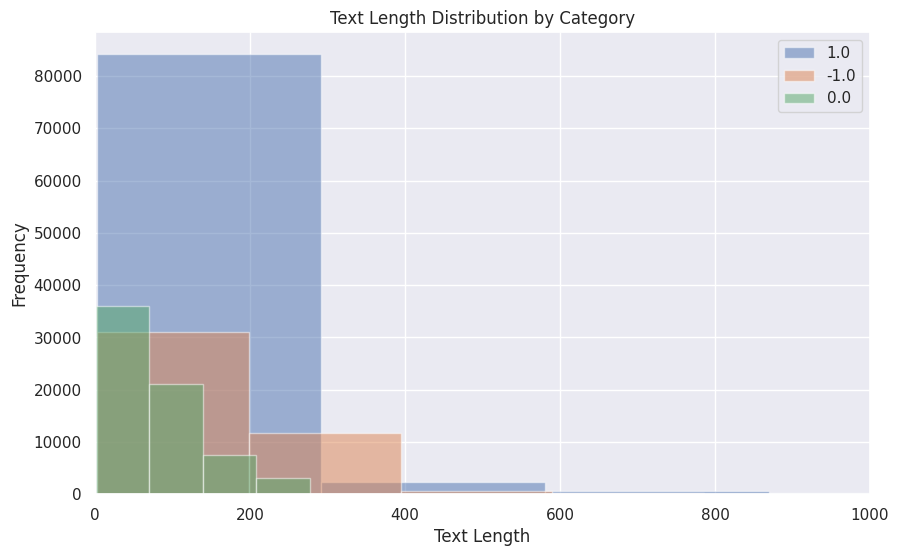

In [20]:
df['text_length'] = df['clean_comment'].apply(len)
plt.figure(figsize=(10, 6))
for category in df['category'].unique():
    subset = df[df['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [21]:
all_text = " ".join(df['clean_comment'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

NameError: ignored

In [22]:
targets = df['category']
comments = df['clean_comment']

In [23]:
targets.value_counts()

 1.0    87992
 0.0    67961
-1.0    43755
Name: category, dtype: int64

In [24]:
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(targets)
targets

array([2, 2, 0, ..., 1, 1, 2])

- 0 = Negetive
- 1 = Neutral
- 2 = Positive

In [25]:
def count_words(sentence):
    if isinstance(sentence, str):
        words = sentence.split()
        return len(words)
    else:
        return 0

df['word_counts'] = df['clean_comment'].apply(count_words)

In [26]:
df['word_counts'].describe()

count    199708.000000
mean         21.851904
std          26.541842
min           0.000000
25%          10.000000
50%          18.000000
75%          29.000000
max        1307.000000
Name: word_counts, dtype: float64

In [27]:
max_word_count_index = df['word_counts'].idxmax()
row_with_max_word_count = df.loc[max_word_count_index]
row_with_max_word_count

clean_comment    brilliant point point breakdown one other argu...
category                                                       1.0
text_length                                                   8665
word_counts                                                   1307
Name: 8646, dtype: object

In [28]:
X_train, X_test, y_train, y_test = train_test_split(comments, targets, test_size=0.2, random_state=42)

In [29]:
max_words = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)

In [30]:
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [31]:
embedding_dim = 100
batch_size = 64
epochs = 10

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [32]:
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
2247/2247 [==============================] - 88s 36ms/step - loss: 0.2886 - accuracy: 0.9009 - val_loss: 0.1584 - val_accuracy: 0.9537
Epoch 2/10
2247/2247 [==============================] - 33s 15ms/step - loss: 0.1283 - accuracy: 0.9643 - val_loss: 0.1240 - val_accuracy: 0.9655
Epoch 3/10
2247/2247 [==============================] - 25s 11ms/step - loss: 0.1031 - accuracy: 0.9717 - val_loss: 0.1236 - val_accuracy: 0.9640
Epoch 4/10
2247/2247 [==============================] - 20s 9ms/step - loss: 0.0835 - accuracy: 0.9772 - val_loss: 0.1236 - val_accuracy: 0.9662
Epoch 5/10
2247/2247 [==============================] - 21s 9ms/step - loss: 0.0675 - accuracy: 0.9807 - val_loss: 0.1345 - val_accuracy: 0.9637
Epoch 6/10
2247/2247 [==============================] - 24s 11ms/step - loss: 0.0552 - accuracy: 0.9840 - val_loss: 0.1369 - val_accuracy: 0.9653
Epoch 7/10
2247/2247 [==============================] - 29s 13ms/step - loss: 0.0426 - accuracy: 0.9875 - val_loss: 0.1644 - v

In [33]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1249/1249 [==============================] - 6s 4ms/step - loss: 0.1986 - accuracy: 0.9612
Test Loss: 0.1986
Test Accuracy: 0.9612


In [34]:
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

1249/1249 [==============================] - 4s 3ms/step


In [35]:
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.9611
Precision: 0.9611
Recall: 0.9612


In [36]:
model.save('LSTM_model.h5')

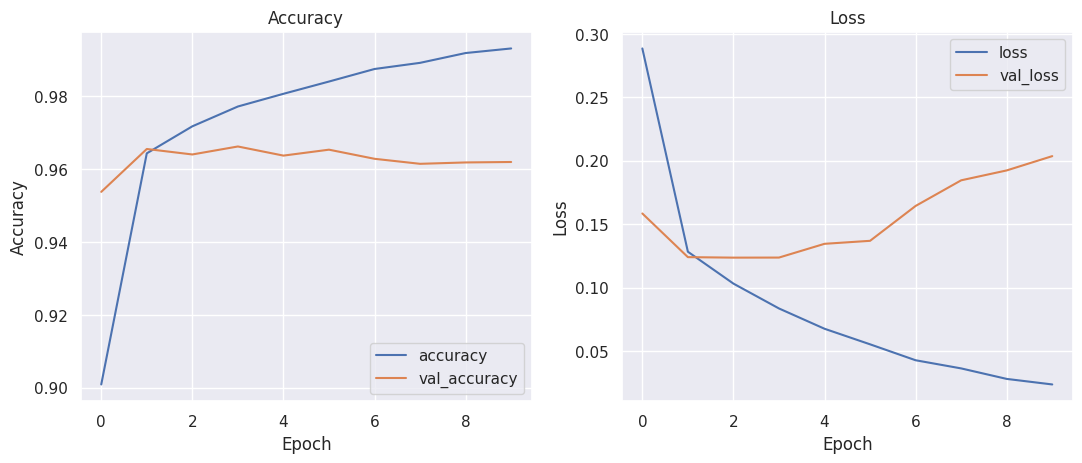

In [37]:
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [38]:
user_input = "You are the worst!!, so sorry for you"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('LSTM_model.h5')
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}

user_predictions = loaded_model.predict(user_padded)

user_pred_classes = np.argmax(user_predictions, axis=1)

print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 635ms/step
Predicted Class: Negative


In [41]:
user_input = "it's raining today"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Sentiment_analysis/LSTM_model.h5')
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}

user_predictions = loaded_model.predict(user_padded)

user_pred_classes = np.argmax(user_predictions, axis=1)

print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 554ms/step
Predicted Class: Neutral


In [44]:
user_input = "i'm verry glad you're here today"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Sentiment_analysis/LSTM_model.h5')
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}

user_predictions = loaded_model.predict(user_padded)

user_pred_classes = np.argmax(user_predictions, axis=1)

print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 572ms/step
Predicted Class: Positive
